# Milestone 5 : Approche supervisée Sentence embedding

## Libraries & Settings

In [29]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
import gensim
from transformers import BertTokenizer, BertModel
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import tensorflow_hub as hub





import matplotlib.pyplot as plt
import matplotlib as mlt

import seaborn as sns

# Set consistent style for all plots
sns.set_style("darkgrid")
# Use a visually appealing color palette
sns.set_palette("vlag")
# Customize plot elements for uniform formatting
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2})
# Further customization of labels and ticks
sns.set(rc={
    'axes.labelsize': 10,      
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,    
    'axes.labelcolor': 'gray', 
    'xtick.color': 'gray', 
    'ytick.color': 'gray',
    'axes.titlesize': 12,    
})


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')

#settings
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package maxe

## Load Data

In [5]:
df = pd.read_csv("C:/Users/lzeferino/Downloads/QueryResults.csv")
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  0 non-null      float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB
None


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How to convert Decimal to Double in C#?,"<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opacity&quot;.</p>\n<pre class=""lang-cs prettyprint-override""><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the app it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type decimal to double</p>\n</blockquote>\n",<c#><floating-point><type-conversion><double><decimal>,4,812,78485,NaN,13


#### Observations about the data

**Data Structure**
   - The dataset contains **50,000 entries** with 8 columns in total.

**Columns Overview**
   - **Title:** This column contains the titles of questions. It is a crucial feature since it often summarizes the question.
   - **Body:** This column contains the main content of the questions. Like the title, all 50,000 entries are non-null.
   - **Tags:** This column contains tags associated with each question, and all entries are non-null. These tags typically represent the key topics or technologies related to the question.
   - **Id:** A unique identifier for each question.
   - **Score:** This column represents the score or rating of each question. It contains non-null integer values for all entries, indicating user engagement.
   - **ViewCount:** This column indicates how many times each question has been viewed. It has non-null values for all entries.
   - **FavoriteCount:** This column contains only null values (`NaN`) across the entire dataset.
   - **AnswerCount:** This column contains non-null integer values for all entries and represents the number of answers each question has received.

**Observations**
   - **Title and Body:** These two columns will require preprocessing. They will be used for creating new features.
   - **Tags:** The tags provide predefined categories or topics. Can be helpful for supervised machine learning. 
   - **Score and ViewCount:** Higher scores and view counts might indicate better-quality questions or topics of higher interest.
   - **AnswerCount:** This can be used to assess the popularity and relevance of a question. More answers generally suggest higher engagement from the community.
   - **FavoriteCount and Id:**: Need to be removed

## Preprocessing

In [6]:
# Sample 10% of the data
df = df.sample(frac=0.2, random_state=42)

# Drop unnecessary columns
df.drop(columns=['Id', 'FavoriteCount', 'Score', 'ViewCount', 'AnswerCount'], inplace=True)

### Cleaning Target column

In [7]:
def preprocess_y(word):
    words = re.findall(r'(?<=<)(.*?)(?=>)', word) # Extract words between angle brackets
    words = ' '.join(words) # Combine extracted words into a single string for further processing
    words = re.sub(r'\d+', '', words)  # Remove all numbers
    words = re.sub(r'\.(?!net\b)', ' ', words) # Preserve ".net" and remove periods from other words
    words = re.sub(r"[^c\#|c\+\+|\.net|\w\s]", " ", words)  # Keep only alphanumeric characters and specified languages (C#, C++, .NET)  
   
    processed_words = []
    for w in words.split():  # Split hyphenated words into separate words
        split_words = w.split('-')        
        processed_words.extend(split_words)  # Add all split words to the list
    processed_words = [w for w in processed_words if 2 <= len(w) <= 20]
    return processed_words

# Apply the function
df['Tags'] = df['Tags'].apply(preprocess_y)


### Preprocess "Body" and "Title"

In [8]:
# Cleanning---------------------
def clean_text(sentence):
    # Remove HTML tags
    soup = BeautifulSoup(sentence, "html.parser")
    sentence = soup.get_text()
    
    # Lowercase the text
    sentence = sentence.lower()

    # Remove special characters except for allowed ones
    sentence = re.sub(r"[^c\#|c\+\+|\.net|\w\s]", "", sentence)  
    
    # Remove all numbers
    sentence = re.sub(r'\d+', '', sentence)  
    
    # Remove words containing underscores and any other unwanted characters
    sentence = ' '.join([word for word in sentence.split() if '_' not in word and word.isascii() and not any(char.isdigit() for char in word)])
    
    # Remove extra whitespace
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    return sentence

# applying
# df['Title_clean'] = df['Title'].apply(clean_text)
# df['Body_clean'] = dfBody'].apply(clean_text)
# df.head(2)

In [9]:
# Tokenize sentence ---------------
from nltk.tokenize import RegexpTokenizer
def tokenize_text(cleaned_sentence):
    tokenizer = RegexpTokenizer(r"(c\#|c\+\+|\.net|\w+)")
    tokens = tokenizer.tokenize(cleaned_sentence)
    return tokens

In [10]:
# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english')))

def stop_word_filter(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) >= 2]
    return filtered_w2

In [11]:
# Lemmatizer 
from nltk.stem import WordNetLemmatizer
def lemma_words(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w, pos='v') for w in list_words] # (base d'un mot - verb)
    return lem_w

The reason you have different transformation functions for bag-of-words (BoW) and deep learning (DL) models stems from the different ways these models process text and their respective needs for feature representation.

1. Bag of Words (BoW): 
   - In models like CountVectorizer, Tf-idf, or Word2Vec, the text is treated as a collection of words where the frequency or importance of words matters.
   - These models often work better with text that is cleaned more aggressively. For example, removing stop words, punctuation, converting everything to lowercase, and lemmatizing or stemming the words helps reduce the dimensionality and makes the word counts or tf-idf features more meaningful.
   - Lemmatization, lowercasing, and stop-word removal ensure that different forms of the same word (e.g., "run," "running") are treated as the same word, reducing redundancy and making the representation more efficient for traditional machine learning models.

2. Deep Learning (e.g., BERT, USE):
   - In deep learning models, which often use word embeddings, the models learn complex semantic relationships between words, so they don't rely on simple word counts or frequencies.
   - These models handle some level of linguistic complexity internally and can learn the meanings of words in context. Hence, there's less need to aggressively clean the data by removing stop words or lemmatizing words. These transformations might strip away useful context that models like BERT use to understand sentence structure and meaning.
   - The deep learning models often benefit from keeping the text closer to its original form, though lowercasing is still often useful as it prevents the model from treating "Apple" and "apple" as completely unrelated tokens.

- **BoW-based models** benefit from aggressive preprocessing (stop-word removal, lemmatization) to reduce the vocabulary size and improve model performance by focusing on key words.
- **Deep learning models** (USE, BERT) benefit from keeping the text more intact, as they can handle richer linguistic structures and learn from the contextual relationships between words.

* Preprocessing functions for Bow and Deep Learning

In [ ]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def preprocess_dl(desc_text) :
    clean_df = clean_text(desc_text)
    word_tokens = tokenize_text(clean_df)
    # sw = stop_word_filter_fct(word_tokens)
    # lw = lemma_words(word_tokens)
    # lem_w = lemma_fct(lw)    
    #preprocess_text = ' '.join(word_tokens)
    return word_tokens

# applying
df['title_clean'] = df['Title'].apply(preprocess_dl)
df['body_clean'] = df['Body'].apply(preprocess_dl)
df.head(2)

C:\Users\lzeferino\AppData\Local\Temp\ipykernel_13180\1766870745.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence, "html.parser")


,Title,Body,Tags,title_clean_bow,body_clean_bow
33553,Confusion about virtual/new/override,"<p>I am a bit confused about the <code>virtual</code>/<code>new</code>/<code>override</code> thing. Here's an example:</p>\n\n<pre><code>class A\n{\n public virtual void mVVirtual() { Console.WriteLine(""A::mVVirtual""); }\n}\n\nclass B : A\n{\n public virtual void mVVirtual() { Console.WriteLine(""B::mVVirtual""); }\n}\n\nclass C : B\n{\n public override void mVVirtual() { Console.WriteLine(""C::mVVirtual""); }\n}\n\n\nclass Test\n{\n static void Main()\n {\n B b1 = new C();\n b1.mVVirtual(); //C::mVVirtual ... I understand this\n\n A a2 = new C();\n a2.mVVirtual(); //A::mVVirtual ... ???\n }\n}\n</code></pre>\n\n<p>I don't get why in the second call we get <code>A::mVVirtual</code>. I usually treat these issues with this ""algorithm"":</p>\n\n<ol>\n<li>Check the type of the variable holding the reference for the object for an instance method called <code>mVVirtual</code>? Doesn't have one...but does have a virtual method with that signature and name!</li>\n<li>Virtual method? Let's then check the type of the object being held by <code>a2</code> (<code>C</code>) for an overriding of that method. It has one -> Executes <code>C::mVVirtual</code>!</li>\n</ol>\n\n<p>Where is my ""algorithm"" wrong? I really am confused by this, and would greatly appreciate some help.</p>\n","[c#, virtual, overriding, new, operator, keyword]","[confusion, virtualnewoverride]","[bite, confuse, virtualnewoverride, thing, heres, example, class, public, virtual, void, mvvirtual, console, writelineamvvirtual, class, public, virtual, void, mvvirtual, console, writelinebmvvirtual, class, public, override, void, mvvirtual, console, writelinecmvvirtual, class, test, static, void, main, new, mvvirtual, cmvvirtual, understand, new, mvvirtual, amvvirtual, dont, get, second, call, get, amvvirtual, usually, treat, issue, algorithm, check, type, variable, hold, reference, object, instance, method, call, mvvirtual, doesnt, one, virtual, method, signature, name, virtual, method, let, check, type, object, hold, override, method, one, execute, cmvvirtual, algorithm, wrong, really, confuse, would, greatly, appreciate, help]"
9427,Xcode debugging: View value of NSNumber?,"<p>Is it possible to see the numeric value of an NSNumber in the debugger datatip on in the variable watch window?</p>\n\n<p>I store an Integer value in NSNumber and want to see this value during debugging.</p>\n\n<p>I tried some of the data formatters in the debugger already, but it wasn't much help. </p>\n","[cocoa, xcode, debugging, nsnumber, data, formatters]","[xcode, debug, view, value, nsnumber]","[possible, see, numeric, value, nsnumber, debugger, datatip, variable, watch, window, store, integer, value, nsnumber, want, see, value, debug, try, data, formatters, debugger, already, wasnt, much, help]"


## Multi Label Binarizer

In [22]:
# Initialize and fit-transform the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tags'])
y = pd.DataFrame(y, columns=mlb.classes_)

# Count the number of occurrences for each tag
tag_counts = y.sum().sort_values(ascending=False)

# Display the top N popular tags
top_n = 20
top_tags = tag_counts.head(top_n).index

# Filter the DataFrame to only include the top N tags
y = y[top_tags]
y

,c#,java,c++,asp.net,javascript,php,sql,iphone,jquery,python,server,windows,html,objective,database,visual,ruby,web,mysql,studio
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Split Train/Test

In [ ]:
# Combine "Title" and "Body" for the Bag of Words approach
df['combined_text'] = df['title_clean'] + df['body_clean'] 
df['combined_text'] = df['combined_text'].apply(lambda x: ' '.join(x)) # Join the list of words into a string
X = df['combined_text']

In [24]:
# Split the dfs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)
print('y Train Shape:', y_train.shape)
print('y Test Shape:', y_test.shape)

# Save the target variables
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

X Train Shape: (8000,)
X Test Shape: (2000,)
y Train Shape: (8000, 20)
y Test Shape: (2000, 20)


## Word2Vec

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

In [ ]:
# Tokeniser chaque texte en une liste de mots
X_train_tokenized = [text.split() for text in X_train]
X_test_tokenized = [text.split() for text in X_test]

# Entraîner Word2Vec sur les données d'entraïnement
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=20)

# Obtenir la représentation des documents en moyenne des vecteurs des mots
def vectorize_with_word2vec(model, documents):
    document_vectors = []
    for doc in documents:
        word_vectors = [model.wv[word] for word in doc if word in model.wv]
        if word_vectors:  # Si le document contient des mots du modèle
            document_vectors.append(np.mean(word_vectors, axis=0))
        else:  # Si aucun mot du document n'est dans le modèle
            document_vectors.append(np.zeros(model.vector_size))
    return np.array(document_vectors)

# Vectorisation des données d'entraînement et de test
X_train_w2v = vectorize_with_word2vec(word2vec_model, X_train_tokenized)
X_test_w2v = vectorize_with_word2vec(word2vec_model, X_test_tokenized)

print('Vocabulary size:', len(word2vec_model.wv))
print("Shape of X_train_w2v:", X_train_w2v.shape)
print("Shape of X_test_w2v:", X_test_w2v.shape)

# word2vec_model.wv.index_to_key
# word2vec_model.corpus_count
# word2vec_model.epochs
word2vec_model.wv.similar_by_word('google')
# word2vec_model.wv['google'].shape
# word2vec_model.wv['google']

# X_train_tokenized[1]
# X_train_w2v[1]

Vocabulary size: 2981
Shape of X_train_w2v: (7561, 100)
Shape of X_test_w2v: (1891, 100)


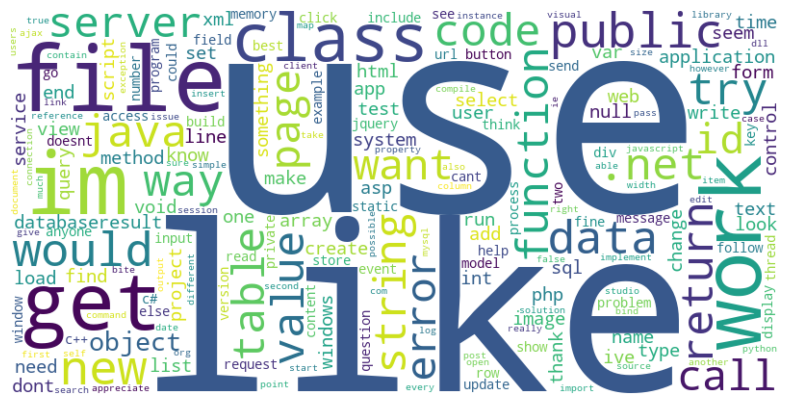

In [113]:
# Count the frequency of each word in the training set
word_counts = Counter(word for doc in X_train_tokenized for word in doc)

# Create a dictionary mapping each word to its weighted vector sum
word_vectors_weighted_sum = {}
for word, count in word_counts.items():
    if word in word2vec_model.wv:  # Ensure the word is in the Word2Vec model
        word_vectors_weighted_sum[word] = count * word2vec_model.wv[word]

# Calculate the average vector for the words to use in the word cloud
wordcloud_weights = {word: np.linalg.norm(vector) for word, vector in word_vectors_weighted_sum.items()}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_weights)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## BERT (Bidirectional Encoder Representations from Transformers)

https://tinkerd.net/blog/machine-learning/bert-embeddings/


“The man was accused of robbing a bank.” “The man went fishing by the bank of the river.”
Word2Vec would produce the same word embedding for the word “bank” in both sentences, while under BERT the word embedding for “bank” would be different for each sentence.


We can’t use the pre-tokenized version because, in order to apply the pre-trained BERT, we must use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In [ ]:
# Charger le tokenizer et le modèle BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Fonction pour générer les embeddings de phrase avec BERT
def vectorize_with_bert(texts):
     all_embeddings = []
     for text in texts:
         inputs = tokenizer(text, max_length=64, truncation=True, padding=True, return_tensors='pt')
         with torch.no_grad():
             outputs = model(**inputs)
         # Extraire le vecteur de [CLS] token
         cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
         all_embeddings.append(cls_embedding)
     return np.array(all_embeddings)

# Vectorisation des données d'entraînement et de test avec BERT
X_train_bert = vectorize_with_bert(X_train)
X_test_bert = vectorize_with_bert(X_test)

print("Shape of X_train_bert:", X_train_bert.shape)
print("Shape of X_test_bert:", X_test_bert.shape)

Shape of X_train_bert: (8000, 768)
Shape of X_test_bert: (2000, 768)


In [2]:
print(tokenizer(['iphone']))

NameError: name 'tokenizer' is not defined

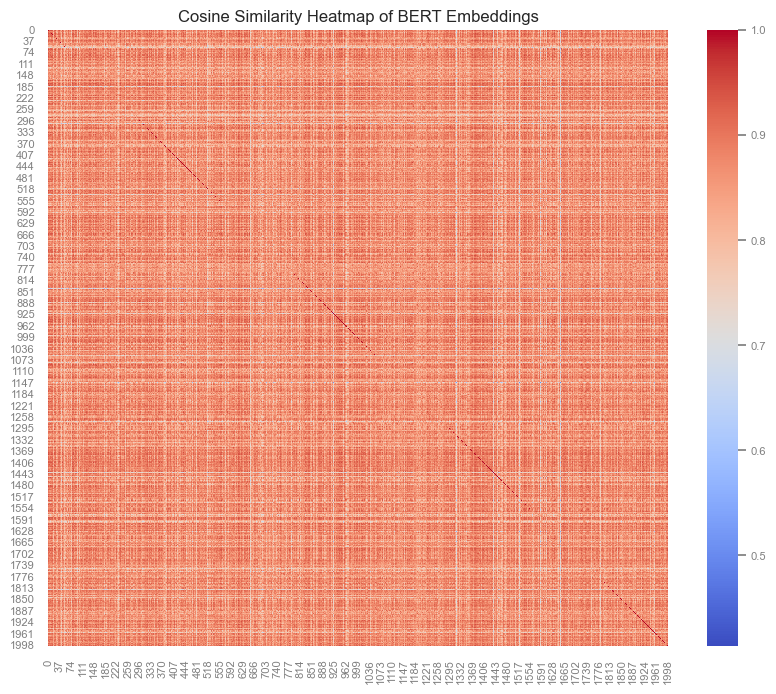

In [91]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between the embeddings
similarity_matrix = cosine_similarity(X_test_bert)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title('Cosine Similarity Heatmap of BERT Embeddings')
plt.show()

In [92]:
import umap

# Apply UMAP to reduce the dimensionality of the BERT embeddings
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(X_test_bert)

# Plot the UMAP result
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_train_single_label, cmap='Spectral', s=5)
plt.title('UMAP Projection of BERT Embeddings')
plt.colorbar()
plt.show()

ModuleNotFoundError: No module named 'umap'

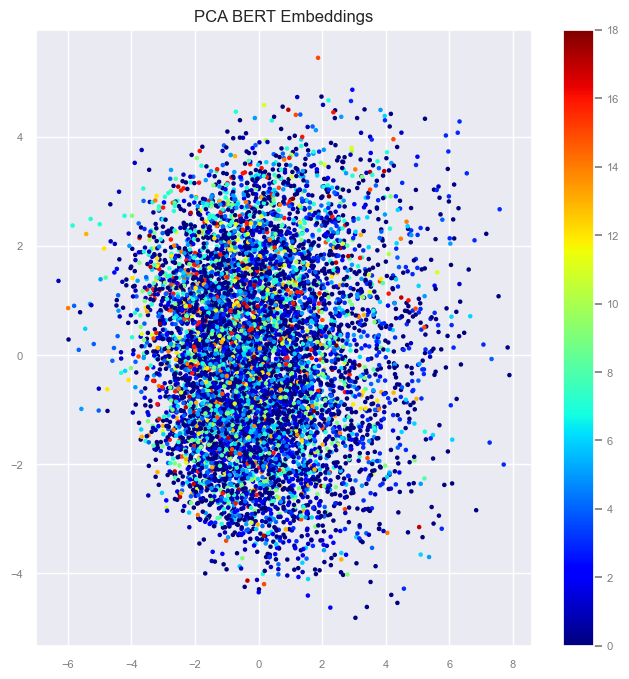

In [93]:
# Function to aggregate labels by selecting the most common tag per row
def get_most_frequent_label(y):
    # Convert multi-label matrix to single-label vector
    return np.argmax(y, axis=1)

y_train_single_label = get_most_frequent_label(y_train)

# Visualization using PCA
def visualize_pca(embeddings, labels, title='PCA visualization'):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='jet', s=5)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage with training data
visualize_pca(X_train_bert, y_train_single_label, title="PCA BERT Embeddings")

In [87]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Fonction pour générer les embeddings de phrase avec BERT
def vectorize_with_bert(texts):
    all_embeddings = []
    for text in texts:
        inputs = tokenizer(text, max_length=128, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
        # Extraire le vecteur de [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        all_embeddings.append(cls_embedding)
    return np.array(all_embeddings)

# Vectorisation des données d'entraînement et de test avec BERT
X_train_bert = vectorize_with_bert(X_train)
X_test_bert = vectorize_with_bert(X_test)

# Convert to DataFrame and save as CSV
pd.DataFrame(X_train_bert).to_csv('X_train_bert.csv', index=False)
pd.DataFrame(X_test_bert).to_csv('X_test_bert.csv', index=False)

print("Shape of X_train_bert:", X_train_bert.shape)
print("Shape of X_test_bert:", X_test_bert.shape)

## USE

In [31]:
#!pip install tensorflow-hub

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.7 MB 15.9 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 27.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 18.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 2.4/385.0 MB 73.6 MB/s eta 0:00:06
    --------------------------------------- 7.1/385.0 MB 112.2 MB/s eta 0:00:04
   - ------------------------------------- 12.6/385.0 MB 131.2 MB/s eta 0:00:03
   - ------------------------------------- 18.3/385.0 MB 129.5 MB/s eta 0:00:03
   -- ------------------------------------ 23.7/385.0 MB 108.8 MB/s eta 0:00:04
   -- ------------------------------------ 29.3/385.0 MB 108.8 MB/s eta 0:00:0

In [32]:
import tensorflow_hub as hub
# Charger le modèle USE
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour générer les embeddings avec USE
def vectorize_with_use(texts):
    embeddings = use_model(texts)
    return np.array(embeddings)

# Vectorisation des données d'entraînement et de test avec USE
X_train_use = vectorize_with_use(X_train)
X_test_use = vectorize_with_use(X_test)

print("Shape of X_train_use:", X_train_use.shape)
print("Shape of X_test_use:", X_test_use.shape)


Shape of X_train_bert: (7561, 768)
Shape of X_test_bert: (1891, 768)


## Saving vectorized data

In [ ]:
import pickle

# W2V ----------------------------------------------------------
# Save the Word2Vec model
word2vec_model.save('word2vec_model.model')

# Save the vectorized training data
with open('X_train_w2v.pkl', 'wb') as file:
    pickle.dump(X_train_w2v, file)

# Save the vectorized testing data
with open('X_test_w2v.pkl', 'wb') as file:
    pickle.dump(X_test_w2v, file)

# Save the tokenized training and testing data
with open('X_train_tokenized.pkl', 'wb') as file:
    pickle.dump(X_train_tokenized, file)

with open('X_test_tokenized.pkl', 'wb') as file:
    pickle.dump(X_test_tokenized, file)

# BERT ----------------------------------------------------------
# Save the tokenizer
tokenizer.save_pretrained('bert_tokenizer')

# Save the model configuration
model.save_pretrained('bert_model')

# Save the BERT embeddings for the training data
with open('X_train_bert.pkl', 'wb') as file:
    pickle.dump(X_train_bert, file)

# Save the BERT embeddings for the testing data
with open('X_test_bert.pkl', 'wb') as file:
    pickle.dump(X_test_bert, file)

# USE ----------------------------------------------------------
# Save the USE embeddings for the training data
with open('X_train_use.pkl', 'wb') as file:
    pickle.dump(X_train_use, file)

# Save the USE embeddings for the testing data
with open('X_test_use.pkl', 'wb') as file:
    pickle.dump(X_test_use, file)


## Notes

When using `CountVectorizer`, the parameters `max_df` and `min_df` control the filtering of words based on their document frequency. Adjusting these parameters can help reduce noise and focus on more relevant terms in your text data. Here's how to choose appropriate values for these parameters:

### Understanding `max_df` and `min_df`

1. **`max_df`**:
   - This parameter specifies the maximum document frequency for words. Words that appear in more than `max_df` proportion of the documents will be ignored.
   - Common values:
     - **0.5**: Ignore terms that appear in more than 50% of the documents.
     - **0.7**: Ignore terms that appear in more than 70% of the documents.
     - **1.0**: This means no limit, and all terms will be included.

2. **`min_df`**:
   - This parameter specifies the minimum document frequency for words. Words that appear in fewer than `min_df` documents will be ignored.
   - Common values:
     - **1**: Ignore terms that appear in only one document.
     - **2**: Ignore terms that appear in only two documents.
     - **0.01**: Ignore terms that appear in less than 1% of the documents.

### Suggested Values to Try

1. **Initial Testing**:
   - Start with values like `max_df=0.7` and `min_df=2`. This allows for some common terms while filtering out too-frequent and too-rare words.
   
2. **Iterative Refinement**:
   - **Decrease `max_df`**: If you still find too many common words, lower `max_df` to around **0.5** or even **0.4**.
   - **Increase `min_df`**: If you notice a lot of noise or irrelevant terms, increase `min_df` to **3** or **4**.
   - Test combinations, such as `max_df=0.6` and `min_df=3`, to find a balance.

3. **Based on Data Size**:
   - For smaller datasets, you might set `min_df` to a lower number (like **1** or **2**) to retain more features, while for larger datasets, you can afford to set it higher.

